## Import Libraries

In [156]:
# Data Analysis      
import pandas as pd          # data analysis library for handling structured data             
import numpy as np           # mathematical library for working with numerical data
import os, sys
import re
import json
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# from metrics import *
# Add the previous directory to sys.path
sys.path.append(os.path.abspath('../'))

# Now you can import the metrics module
import os 

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import missingno as msno    #visualize missing data
from sklearn.metrics import mean_squared_error, r2_score 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000) 




In [157]:
root_dir = r"C:\Users\pault\OneDrive - University of Oklahoma\GRA - Bio-Manufacturing\1. ML-Cytovance-OU-Research"
os.chdir(root_dir)

## Preprocessing

> Drop invariant columns

In [158]:
# drop invariant columns 
def drop_invariant_columns(df):
    """
    This function takes a list of DataFrames and drops specified invariant columns from each DataFrame.

    Parameters:
    experiment_data (list): List of pandas DataFrames.
    invariant_cols (list): List of column names to be dropped from each DataFrame.

    Returns:
    list: A new list of DataFrames with invariant columns dropped.
    """
    invariant_cols = ['input_vessel_type',	'input_vessel_volume',	'input_vessel_name',	'input_agitation_rpm',	'input_DO_%',	
                  'input_pH_setpoint',	'input_gas_flow',	'input_air_%',	'input_O2',	'input_Temp_c',	'input_media_type',	
                  'input_feed_type',	'input_glucose_limit']
    

    # Create a copy of the DataFrame to avoid modifying the original data.
    updated_df = df.drop(columns=invariant_cols, axis=1)
    return updated_df




> Missing Value Imputation

In [159]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor    

def convert_WCW_zero(df):
    df['output_WCW_gl'] = df.apply(lambda row: 0 if row['input_Timepoint (hr)'] in [0,1, 2] else row['output_WCW_gl'], axis=1)
    # df['output_WCW_gl'] = df.apply(lambda row: 0 if row.name in [pd.Timestamp("2024-01-01 00:00:00"), pd.Timestamp("2024-01-01 01:00:00"), pd.Timestamp("2024-01-01 02:00:00")] else row['output_WCW_gl'], axis=1)
    return df


def impute_missing_values_iteratively(X_a, exclude=None):
    # Convert specific values to zero based on conditions
    X_a = convert_WCW_zero(X_a)
    X = X_a.copy()

    # Normalize the exclude parameter to be a list if it's not None or already a list
    if exclude is not None and not isinstance(exclude, list):
        exclude = [exclude]

    for col in X.columns:
        # Check if column is excluded or if it's 'input_Timepoint (hr)'
        if exclude is not None and col in exclude:
            continue

        # Process columns that are not excluded and meet the conditions
        if X[col].isnull().any() and X[col].dtype == 'object' and col != 'input_Timepoint (hr)':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=100, random_state=0),  # the estimator to predict the NA
        initial_strategy='mean',  # how will NA be imputed in step 1
        max_iter=10,  # number of cycles
        imputation_order='ascending',  # the order in which to impute the variables
        n_nearest_features=None,  # whether to limit the number of predictors
        skip_complete=True,  # whether to ignore variables without NA
        random_state=0,)

    # Select columns that are now either originally numeric or successfully converted from object
    numeric_cols = [col for col in X.select_dtypes(include=['number']).columns if col not in exclude] if exclude is not None else X.select_dtypes(include=['number']).columns

    # Impute missing values only in the selected numeric columns that are not excluded
    X_imputed = imputer.fit_transform(X[numeric_cols])
    X_a[numeric_cols] = X_imputed

    return X_a 

> Scale and Concat

In [160]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Use StandardScaler for this
scale_cols = ['output_WCW_gl', 'output_agitation', 'output_air_%', 'output_D0_%', 'output_gasflow', 'output_O2', 'output_Ph', 
              'output_feed_%', 'output_feed', 'output_Temp', 'output_glycerol_gl', 
              'output_glucose_gl', 'output_acetate_mmol_l', 'output_phosphate_mmol_l']

def scale_and_concat(X, columns_to_transform = scale_cols, train = False, scaler = None):
    """
    Scales selected columns in a DataFrame using StandardScaler and concatenates them with the rest of the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        columns_to_transform (list): List of column names to be scaled.

    Returns:
        pandas.DataFrame: The concatenated DataFrame with scaled columns.
    """
    
    # Filter out columns in 'columns_to_transform' that are not present in 'X'
    valid_columns = [col for col in columns_to_transform if col in X.columns]
    
    if train == True:
        # scaler = MinMaxScaler() # Initialize the scaler 
        scaler = StandardScaler()   # Initialize the scaler
        scaler.fit(X[valid_columns])  # Fit only on the training set
    else:
        scaler = scaler

    # Create a copy of the original DataFrame
    df_concatenated = X.copy()

    # Scale the selected columns
    scaled_columns = scaler.transform(X[valid_columns])

    # Create a DataFrame with the scaled columns
    df_scaled = pd.DataFrame(scaled_columns, columns=valid_columns, index=X.index)
            
    # Concatenate the scaled columns with the rest of the DataFrame
    df_concatenated = pd.concat([df_concatenated.drop(columns=valid_columns, axis = 1), df_scaled], axis=1)

    if train == True:
        return df_concatenated, scaler
    else:
        return df_concatenated
    



## Building the Model

> Titer Value imputation

In [161]:

import random 


experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict


# def load_data(batch_names, num_impute=len(experiment_names)):   #You can change num_impute to 5. However, for this case i will impute all
#     df_list = []
#     impute_batches = np.random.choice(batch_names, size=num_impute, replace=False) 
#     for b_name in batch_names:
#         df = pd.read_csv(f"titer/data/{b_name}.csv")
#         df = drop_invariant_columns(df)
#         df.name = b_name
#         df['batch'] = b_name
        
#         # Find the first point where 'output_phosphate_mmol_l' <= 3
#         condition_met_idx = df[df['output_phosphate_mmol_l'] <= 5].index.min()
#         df['original_titer'] = df['output_titre_µgl'].copy()        # this copies the original titer for use in plotting 
#         # Check if such a point exists
#         if pd.notnull(condition_met_idx) and condition_met_idx > 1:
#             # Calculate the index two rows up from the found point
#             start_idx = max(condition_met_idx - 2, 0) 
#             # Set 'output_titre_µgl' to 0.0 from start_idx to the beginning of the dataset
#             df.loc[:start_idx, 'output_titre_µgl'] = 0.0
            
#         # Find the last index with 'output_titre_µgl' == 0.0
#         last_zero_idx = df[df['output_titre_µgl'] == 0.0].index.max() 

#         # Determine the last non-NaN value or use the threshold
#         if pd.isnull(df['output_titre_µgl'].iloc[-1]):
#             final_value = random.uniform(0.3, 2.2)  # Threshold value if the last value is NaN
#         else:
#             final_value = df['output_titre_µgl'].dropna().iloc[-1]  # Last non-NaN value

#         # Define the start and end indices for filling
#         start_i = last_zero_idx + 1 if pd.notnull(last_zero_idx) else 0
#         end_i = df.index.max()

#         # Apply the exponential function to fill missing values
#         num_points = end_i - start_i + 1
#         exp_values = np.linspace(0, 1, num_points)
#         exp_values = final_value * (np.exp(exp_values) - 1) / (np.exp(1) - 1)  # Normalized exponential

#         for i, val in zip(range(start_i, end_i + 1), exp_values):
#             if b_name in impute_batches:
#                 df.loc[i, 'output_titre_µgl'] = val
#                 df['input_batch'] = b_name

#         df_list.append(df)
        
#     return df_list


def load_data(batch_names, num_impute = len(experiment_names), fraction_impute=0.8):  # Add fraction_impute parameter
    df_list = []
    impute_batches = np.random.choice(batch_names, size=num_impute, replace=False) 
    for b_name in batch_names:
        df = pd.read_csv(f"titer/data/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        
        # Find the first point where 'output_phosphate_mmol_l' <= 5
        condition_met_idx = df[df['output_phosphate_mmol_l'] <= 5].index.min()
        df['original_titer'] = df['output_titre_µgl'].copy()  # this copies the original titer for use in plotting 
        
        # Check if such a point exists
        if pd.notnull(condition_met_idx) and condition_met_idx > 1:
            # Calculate the index two rows up from the found point
            start_idx = max(condition_met_idx - 2, 0) 
            # Set 'output_titre_µgl' to 0.0 from start_idx to the beginning of the dataset
            df.loc[:start_idx, 'output_titre_µgl'] = 0.0
            
        # Find the last index with 'output_titre_µgl' == 0.0
        last_zero_idx = df[df['output_titre_µgl'] == 0.0].index.max() 

        # Determine the last non-NaN value or use the threshold
        if pd.isnull(df['output_titre_µgl'].iloc[-1]):
            final_value = random.uniform(0.3, 2.2)  # Threshold value if the last value is NaN
        else:
            final_value = df['output_titre_µgl'].dropna().iloc[-1]  # Last non-NaN value

        # Define the start and end indices for filling
        start_i = last_zero_idx + 1 if pd.notnull(last_zero_idx) else 0
        end_i = df.index.max() - 1  # Exclude the last time point

        # Apply the exponential function to fill missing values
        num_points = end_i - start_i + 1
        exp_values = np.linspace(0, 1, num_points)
        exp_values = final_value * (np.exp(exp_values) - 1) / (np.exp(1) - 1)  # Normalized exponential

        # Randomly select 60% of the indices to impute
        num_impute_points = int(num_points * fraction_impute)
        indices_to_impute = sorted(random.sample(range(start_i, end_i + 1), num_impute_points))

        for i, val in zip(indices_to_impute, exp_values[:num_impute_points]):
            if b_name in impute_batches:
                df.loc[i, 'output_titre_µgl'] = val
                df['input_batch'] = b_name

        # Set the final value
        if pd.isnull(df.loc[end_i + 1, 'output_titre_µgl']):
            df.loc[end_i + 1, 'output_titre_µgl'] = final_value

        df_list.append(df)
        
    return df_list 



def concatenate_impute_split(experiment_names):
    
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data, exclude = ['output_titre_µgl', 'input_batch', 'original_titer'])  # Impute missing values iteratively to avoid over-fitting on the test set

    # Split the data back into the original batches using the 'batch' column and return as a list
    # batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    batched_dataframes_list = [group for _, group in full_data_inputed.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def titer_imputation(experiment_names):
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Trial and Error: scale and cocatenate the dataset
    dataset = pd.concat(df_batch_list, ignore_index=True)

    return dataset



dataset = titer_imputation(experiment_names)

In [162]:
dataset

,input_Timepoint (hr),output_OD600,output_WCW_gl,output_agitation,output_air_%,output_D0_%,output_gasflow,output_O2,output_Ph,output_feed_%,output_feed,output_Temp,output_glycerol_gl,output_glucose_gl,output_acetate_mmol_l,output_phosphate_mmol_l,output_titre_µgl,batch,original_titer,input_batch
0,0.0,0.353000,0.000,1185.440000,100.000000,96.810000,5.010000,0.000000,6.910000,0.00,0.00000,30.19,6.4300,0.243000,1.9500,18.0000,0.000000,exp_210623_1,NaN,exp_210623_1
1,2.0,0.547000,0.000,1185.320000,100.000000,97.950000,5.000000,0.000000,6.775341,0.00,0.00000,29.99,5.2310,0.181900,3.7795,21.8014,0.000000,exp_210623_1,NaN,exp_210623_1
2,4.0,1.590000,0.000,1185.220000,100.000000,94.600000,5.000000,0.000000,6.850000,0.00,0.00000,30.01,6.4305,-0.004392,9.5241,27.5919,0.000000,exp_210623_1,NaN,exp_210623_1
3,6.0,4.460000,56.805,1184.830000,100.000000,82.450000,5.000000,0.000000,6.780000,0.00,0.00000,30.04,4.0480,-0.005319,15.6948,25.3705,0.000000,exp_210623_1,NaN,exp_210623_1
4,8.0,11.320000,51.770,1184.500000,100.000000,66.110000,5.000000,0.000000,6.710000,0.00,0.00000,29.99,0.0000,0.000000,15.6100,14.4700,0.000000,exp_210623_1,NaN,exp_210623_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679,32.0,83.600000,207.500,1184.912964,99.576492,40.890980,4.793379,0.422386,6.194422,10.60,0.36040,25.99,0.2718,19.202700,4.0200,-0.0100,0.713154,exp_220822_4,NaN,exp_220822_4
680,36.0,87.400000,208.500,1184.800049,99.456673,40.179340,4.711772,0.543087,6.226009,9.01,0.30634,26.00,0.0097,18.399210,2.7800,-0.0200,0.964751,exp_220822_4,NaN,exp_220822_4
681,40.0,93.266667,217.500,1184.574951,99.654694,40.592091,4.850256,0.344494,6.214839,7.66,0.26044,26.01,0.1204,16.133740,4.1000,-0.0300,NaN,exp_220822_4,NaN,exp_220822_4
682,44.0,93.400000,216.500,1185.463989,99.543571,37.069462,4.800520,0.463291,6.221002,6.32,0.21488,25.98,0.0099,11.673240,4.8400,-0.1100,NaN,exp_220822_4,NaN,exp_220822_4


> Synthetic Dataset

In [163]:
import numpy as np
import matplotlib.pyplot as plt

class TimeSeriesDataGenerator:
    def __init__(self, w, t, a, b, mod):
        """
        Initialize the TimeSeriesDataGenerator with the given parameters.

        Parameters:
        w: int
            Window length.
        t: float
            Parameter of abnormal pattern.
        a: int
            Size of Normal class.
        b: int
            Size of abnormal class.
        mod: int
            If mod==1 SVM is running, if mod==2 WSVM is running.
        """
        self.w = w
        self.t = t
        self.a = a
        self.b = b
        self.mod = mod
        self.data = None
        self.labels = None
        self.weights = None
        self.binary = False

    def generate_binary_class_data(self, abtype):
        """
        Generate binary classification time series data with labels and weights.
        
        Parameters:
        abtype: int
            Abnormal type (e.g. 1: Uptrend, 2: Downtrend, 3: Upshift, 4: Downshift, 5: Cyclic, 6: Systematic, 7: Stratification)
        """
        s = np.arange(1, self.w + 1)

        # Generate Normal data points
        data1 = np.random.randn(self.a, self.w)

        # Generate Abnormal data points
        data2 = np.zeros((self.b, self.w))
        for i in range(self.b):
            if abtype == 1:
                data2[i] = np.random.randn(self.w) + self.t * s  # Uptrend(+)
            elif abtype == 2:
                data2[i] = np.random.randn(self.w) - self.t * s  # Downtrend(-)
            elif abtype == 3:
                data2[i] = np.random.randn(self.w) + self.t * np.ones(self.w)  # Upshift(+)
            elif abtype == 4:
                data2[i] = np.random.randn(self.w) - self.t * np.ones(self.w)  # Downshift(-)
            elif abtype == 5:
                data2[i] = np.random.randn(self.w) + self.t * (-1) ** s  # Systematic pattern
            elif abtype == 6:
                data2[i] = np.random.randn(self.w) + self.t * np.cos(2 * np.pi * s / 8)  # Cyclic pattern
            elif abtype == 7:
                data2[i] = self.t * np.random.randn(self.w)  # Stratification

        # Combine Normal and Abnormal data
        data = np.vstack((data1, data2))

        # Label the data: 1 for Normal data and 0 for Abnormal data
        labels = np.hstack((np.ones(self.a), np.zeros(self.b)))
        data = np.hstack((data, labels.reshape(-1, 1)))

        # Weights: when mod==2 (WSVM), assign all data points the weights as inverse of the class size otherwise assign all data points the weight equal to one (SVM)
        if self.mod == 2:
            weights = np.hstack((np.ones(self.a) / self.a, np.ones(self.b) / self.b))
        else:
            weights = np.ones(self.a + self.b)

        data = np.hstack((data, weights.reshape(-1, 1)))

        self.data = data
        self.labels = labels
        self.weights = weights
        self.binary = True

    def generate_multiclass_data(self, abtypes):
        """
        Generate multiclass classification time series data with labels and weights.
        
        Parameters:
        abtypes: list
            List of abnormal types (e.g. [1, 2, 3, 4, 5, 6, 7])
        """
        s = np.arange(1, self.w + 1)
        num_classes = len(abtypes) + 1  # Normal class + number of abnormal classes

        # Generate Normal data points
        data1 = np.random.randn(self.a, self.w)

        # Generate Abnormal data points
        data2 = []
        labels = []

        for idx, abtype in enumerate(abtypes, start=1):
            for _ in range(self.b):
                if abtype == 1:
                    data = np.random.randn(self.w) + self.t * s  # Uptrend(+)
                elif abtype == 2:
                    data = np.random.randn(self.w) - self.t * s  # Downtrend(-)
                elif abtype == 3:
                    data = np.random.randn(self.w) + self.t * np.ones(self.w)  # Upshift(+)
                elif abtype == 4:
                    data = np.random.randn(self.w) - self.t * np.ones(self.w)  # Downshift(-)
                elif abtype == 5:
                    data = np.random.randn(self.w) + self.t * (-1) ** s  # Systematic pattern
                elif abtype == 6:
                    data = np.random.randn(self.w) + self.t * np.cos(2 * np.pi * s / 8)  # Cyclic pattern
                elif abtype == 7:
                    data = self.t * np.random.randn(self.w)  # Stratification

                data2.append(data)
                labels.append(idx)  # Label according to the abnormal type

        data2 = np.array(data2)

        # Combine Normal and Abnormal data
        data = np.vstack((data1, data2))

        # Label the data: 0 for Normal data and 1, 2, 3,... for Abnormal data
        labels = np.hstack((np.zeros(self.a), np.array(labels)))
        data = np.hstack((data, labels.reshape(-1, 1)))

        # Weights: when mod==2 (WSVM), assign all data points the weights as inverse of the class size otherwise assign all data points the weight equal to one (SVM)
        if self.mod == 2:
            weights_normal = np.ones(self.a) / self.a
            weights_abnormal = np.ones(len(labels) - self.a) / self.b
            weights = np.hstack((weights_normal, weights_abnormal))
        else:
            weights = np.ones(self.a + len(labels) - self.a)

        data = np.hstack((data, weights.reshape(-1, 1)))

        self.data = data
        self.labels = labels
        self.weights = weights
        self.binary = False

    def get_data(self):
        """
        Return the generated data.
        """
        if self.data is None:
            raise ValueError("Data not generated. Please call generate_data() first.")
        return self.data[:, :-2]

    def get_labels(self):
        """
        Return the labels of the generated data.
        """
        if self.labels is None:
            raise ValueError("Data not generated. Please call generate_data() first.")
        return self.labels

    def get_weights(self):
        """
        Return the weights of the generated data.
        """
        if self.weights is None:
            raise ValueError("Data not generated. Please call generate_data() first.")
        return self.weights

    def visualize_data(self, abtypes_to_visualize=None):
        """
        Visualize the generated time series data.
        
        Parameters:
        abtypes_to_visualize: list
            List of abnormal types to visualize along with normal data.
            If None, visualize all abnormal types and normal data.
        """
        if self.data is None:
            raise ValueError("Data not generated. Please call generate_data() first.")
        
        plt.figure(figsize=(10, 6))

        abtype_names = {
            1: 'Uptrend',
            2: 'Downtrend',
            3: 'Upshift',
            4: 'Downshift',
            5: 'Systematic',
            6: 'Cyclic',
            7: 'Stratification'
        }

        if self.binary:
            label_names = {0: 'Abnormal', 1: 'Normal'}
        else:
            if abtypes_to_visualize is None:
                abtypes_to_visualize = list(abtype_names.keys())
            label_names = {0: 'Normal'}
            for idx in abtypes_to_visualize:
                label_names[idx] = f'Abnormal {abtype_names[idx]}'

        colors = plt.cm.get_cmap('tab10', len(label_names))

        # Plot data
        for i in range(len(self.labels)):
            label = int(self.data[i, -2])
            if label in label_names:
                plt.plot(self.data[i, :-2], color=colors(label), alpha=0.3, label=label_names[label] if i == 0 else "")

        # Create legend
        handles = []
        for label, name in label_names.items():
            handles.append(plt.Line2D([0], [0], color=colors(label), lw=2, label=name))
        plt.legend(handles=handles)

        plt.title('Time Series Data Visualization')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.show()


    def online_update(self, new_data, new_labels, aggressive=True):
        """
        Update the model with new samples.

        Parameters:
        new_data: numpy.ndarray
            New data samples to be added.
        new_labels: numpy.ndarray
            Labels for the new data samples.
        aggressive: bool
            If True, update the model weights aggressively. If False, update model weights only for misclassified samples.
        """
        if self.data is None:
            raise ValueError("Data not generated. Please call generate_data() first.")

        # Combine new data with existing data
        combined_data = np.vstack((self.data[:, :-2], new_data))
        combined_labels = np.hstack((self.labels, new_labels))

        # Update class weights
        if self.mod == 2:
            class_counts = np.bincount(combined_labels.astype(int))
            class_weights = np.zeros(len(combined_labels))
            for i, count in enumerate(class_counts):
                class_weights[combined_labels == i] = 1 / count
        else:
            class_weights = np.ones(len(combined_labels))

        # Update model weights based on misclassification if not aggressive
        if not aggressive:
            misclassified = np.where(self.data[:, -1] != self.labels)[0]
            model_weights = np.ones(len(combined_labels))
            model_weights[misclassified] = 0.5  # Example of reducing weight for misclassified samples
        else:
            model_weights = np.ones(len(combined_labels))

        # Store updated data, labels, class weights, and model weights
        self.data = np.hstack((combined_data, combined_labels.reshape(-1, 1), class_weights.reshape(-1, 1)))
        self.labels = combined_labels
        self.class_weights = class_weights
        self.model_weights = model_weights 



# # Example usage for binary classification:
# generator = TimeSeriesDataGenerator(w=48, t=0.5, a=20, b=10, mod=1)
# generator.generate_binary_class_data(abtype=1)
# data = generator.get_data()
# labels = generator.get_labels()
# weights = generator.get_weights()
# print("Data:", data)
# print("Labels:", labels)
# print("Weights:", weights)
# generator.visualize_data()


# # Example usage for multiclass classification:
# generator = TimeSeriesDataGenerator(w=100, t=0.05, a=50, b=10, mod=1)
# abtypes = [1, 2, 3, 4, 5, 6, 7]
# generator.generate_multiclass_data(abtypes=abtypes)
# data = generator.get_data()
# labels = generator.get_labels()
# weights = generator.get_weights()
# print("Data:", data)
# print("Labels:", labels)
# print("Weights:", weights)
# generator.visualize_data(abtypes_to_visualize=[1,3]) # Visualize only Uptrend and Upshift


### Variables:
- \( w \): Window length, the number of time points in each data sample.
- \( t \): Parameter that controls the magnitude of the abnormal pattern.
- \( abtype \): Abnormal type indicator, where different values correspond to different patterns:
  - 1: Uptrend
  - 2: Downtrend
  - 3: Upshift
  - 4: Downshift
  - 5: Systematic pattern
  - 6: Cyclic pattern
  - 7: Stratification
- \( a \): Size of the normal class (number of normal data samples).
- \( b \): Size of the abnormal class (number of abnormal data samples).
- \( s \): Sequence of time points from 1 to \( w \).

### Abnormal Patterns Equations:
1. **Uptrend** (\( abtype = 1 \)):
   \[
   data2[i] = \epsilon + t \cdot s
   \]
   - \( \epsilon \): Random noise, normally distributed.
   - \( s \): Sequence \( [1, 2, \ldots, w] \).

2. **Downtrend** (\( abtype = 2 \)):
   \[
   data2[i] = \epsilon - t \cdot s
   \]

3. **Upshift** (\( abtype = 3 \)):
   \[
   data2[i] = \epsilon + t
   \]
   - \( t \): A constant shift applied to the entire sequence.

4. **Downshift** (\( abtype = 4 \)):
   \[
   data2[i] = \epsilon - t
   \]

5. **Systematic Pattern** (\( abtype = 5 \)):
   \[
   data2[i] = \epsilon + t \cdot (-1)^s
   \]
   - \( (-1)^s \): Alternating sequence \( [(-1)^1, (-1)^2, \ldots, (-1)^w] \).

6. **Cyclic Pattern** (\( abtype = 6 \)):
   \[
   data2[i] = \epsilon + t \cdot \cos\left( \frac{2 \pi s}{8} \right)
   \]
   - \( \cos\left( \frac{2 \pi s}{8} \right) \): Cosine wave pattern with a period of 8.

7. **Stratification** (\( abtype = 7 \)):
   \[
   data2[i] = t \cdot \epsilon
   \]
   - Here, \( t \) scales the random noise \( \epsilon \).


In [164]:
         



# name                            # Name of the generated dataset
# dataset_distribution            # Distribution of data points in each set (train, valid, test)
                                    # Example: 
                                    # {
                                    #   'train': {'normal': 570, 'abnormal_0.2': 6, 'abnormal_0.4': 6, ..., 'abnormal_1': 6},
                                    #   'valid': {'normal': 190, 'abnormal_0.2': 2, 'abnormal_0.4': 2, ..., 'abnormal_1': 2},
                                    #   'imbalanced_test': {'normal': 190, 'abnormal_0.2': 2, 'abnormal_0.4': 2, ..., 'abnormal_1': 2},
                                    #   'balanced_test': {'normal': 100, 'abnormal_0.2': 20, 'abnormal_0.4': 20, ..., 'abnormal_1': 20}
                                    # }
                                
# time_window                     # Length of the generated time-series. Example: 48

# imbalanced_ratio                # Ratio of normal to abnormal data. Example: 0.95
                                    # If set to 0.95, it means across the entire dataset (train, valid, imbalanced_test, balanced_test), 
                                    # 95% of the data points will be normal and 5% will be abnormal.
                                    

# abnormality_parameters          # Parameters defining the type and extent of abnormality in the data
                                    # Example: {'pattern_name': 'uptrend', 'parameter_value': 0.05}
                                        # pattern_name: The type of abnormal pattern to introduce in the data. Examples include:
                                        # 'uptrend': A pattern where the values increase over time.
                                        # 'downtrend': A pattern where the values decrease over time.
                                        # 'upshift': A sudden upward shift in values.
                                        # 'downshift': A sudden downward shift in values.
                                        # 'cyclic': A repeating pattern over a period.
                                        # 'systematic': Alternating increase and decrease in values.
                                        # 'stratification': Variation in values around a mean.
                                        # parameter_value: The magnitude or extent of the abnormal pattern.
                                        # Example: For an 'uptrend' pattern, parameter_value = 0.05 means the values increase by 0.05 units per time step.
                                    
# visualization                   # Flag to indicate whether to visualize the generated data. Example: True

# self.abnormality_rates          # Predefined list of possible abnormality rates. These rates allow the generation of datasets with varying 
                                  # levels of abnormalities, which can be used to train and test models under different conditions of abnormality
                                    # Example: [1, 0.8, 0.6, 0.4, 0.2, 0]
                                        # 1:   Fully abnormal data (100% abnormality)
                                        # 0.8: 80% of the data is abnormal, and 20% is normal
                                        # 0.6: 60% of the data is abnormal, and 40% is normal
                                        # 0.4: 40% of the data is abnormal, and 60% is normal
                                        # 0.2: 20% of the data is abnormal, and 80% is normal
                                        # 0: Fully normal data (0% abnormality)

# batch_size                     # Number of samples per batch in the streaming data simulation
                                    # Example: 10

# batch_interval                 # Time interval (in seconds) between batches in dynamic visualization
                                    # Example: 1



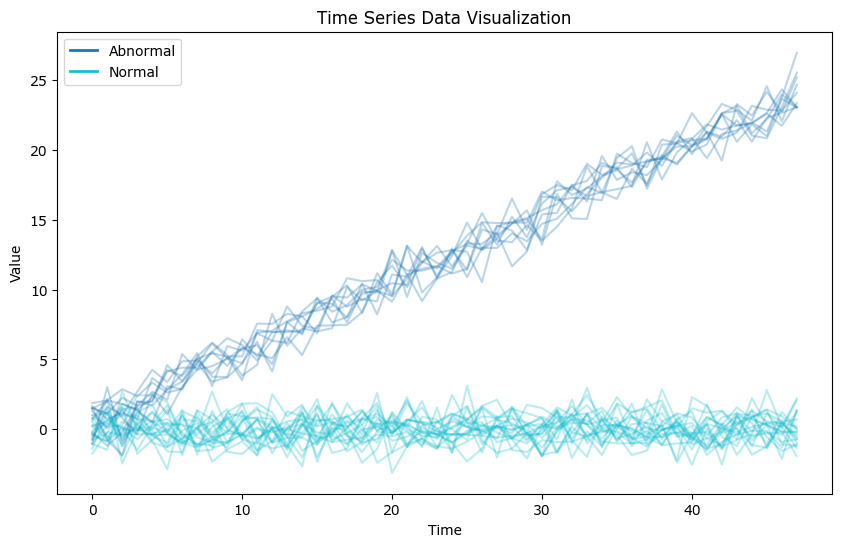

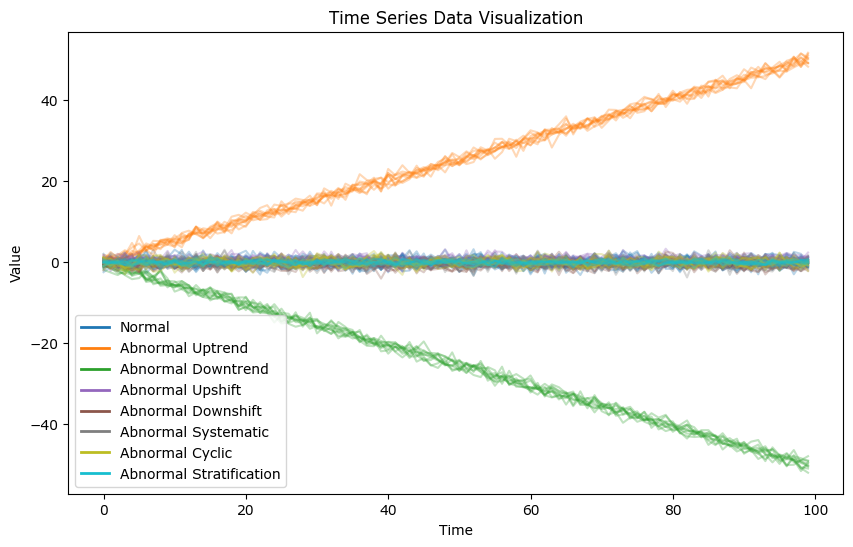

In [165]:
# Example usage for binary classification:
generator = TimeSeriesDataGenerator(w=48, t=0.5, a=20, b=10, mod=1)
generator.generate_binary_class_data(abtype=1)
data = generator.get_data()
labels = generator.get_labels()
weights = generator.get_weights()
# print("Data:", data)
# print("Labels:", labels)
# print("Weights:", weights)
generator.visualize_data()


# Example usage for multiclass classification:
generator = TimeSeriesDataGenerator(w=100, t=0.5, a=25, b=10, mod=1)
abtypes = [1, 2, 3, 4, 5, 6, 7]
generator.generate_multiclass_data(abtypes=abtypes)
data = generator.get_data()
labels = generator.get_labels()
weights = generator.get_weights()
# print("Data:", data)
# print("Labels:", labels)
# print("Weights:", weights)
generator.visualize_data(abtypes_to_visualize=abtypes)

> Data Visualization Questns.

In [166]:
# Here are the problems to generate:

 

# Uptrend: w = 20, t = 0.2 (abnormal values/parameters)
# Downtrend: w = 20, t = 0.2
# Upshift: w=20, t = 0.4 (abnormal values/parameters)
# Downshift: w=20, t = 0.4 (abnormal values/parameters)
# Cyclic: w=20, t = 1.05 (abnormal values/parameters)
# Systematic: w=20, t=0.1 (abnormal values/parameters)
 

In [174]:
generator = TimeSeriesDataGenerator(w=20, t=0.2, a=900, b=100, mod=1)

abtypes = [1, 2, 3, 4, 5, 6, 7]
generator.generate_multiclass_data(abtypes=abtypes)
# generator.visualize_data(abtypes_to_visualize=[1,2, 3])

data = generator.get_data()

data[1]

array([-0.96139838, -1.50965579,  0.86693917,  2.23334813, -0.07684373,
        1.14175974,  0.72882056, -0.57446985, -0.71717737, -1.55852665,
       -0.41287117,  0.15256601,  1.26340244,  0.96557883,  0.84741504,
       -1.45314716, -1.19740346,  1.34489526,  0.64432046, -0.99676591])

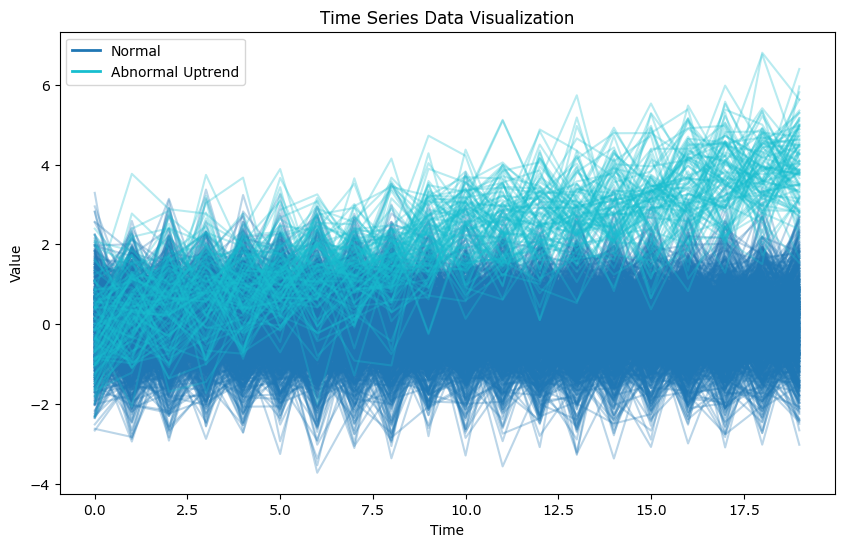

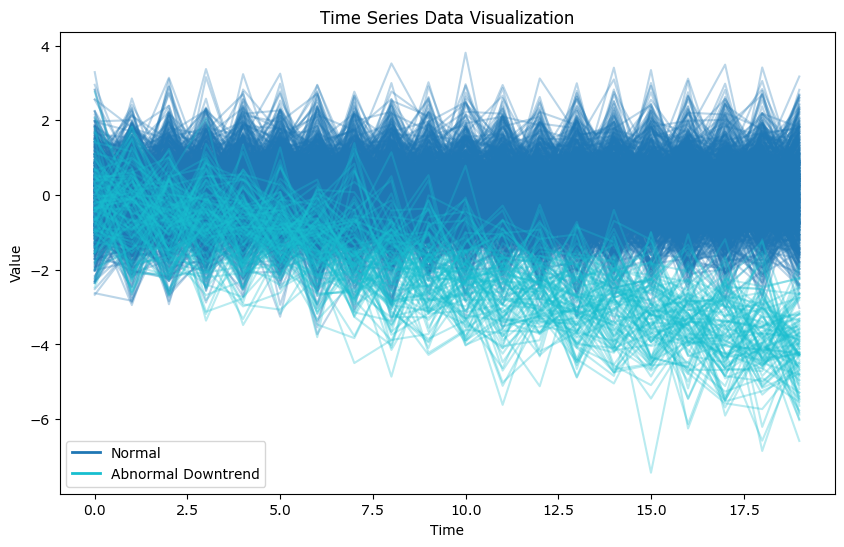

In [152]:
# Example usage for multiclass classification:
generator = TimeSeriesDataGenerator(w=20, t=0.2, a=900, b=100, mod=1)
abtypes = [1, 2, 3, 4, 5, 6, 7]
generator.generate_multiclass_data(abtypes=abtypes)
generator.visualize_data(abtypes_to_visualize=[1])

generator.visualize_data(abtypes_to_visualize=[2])

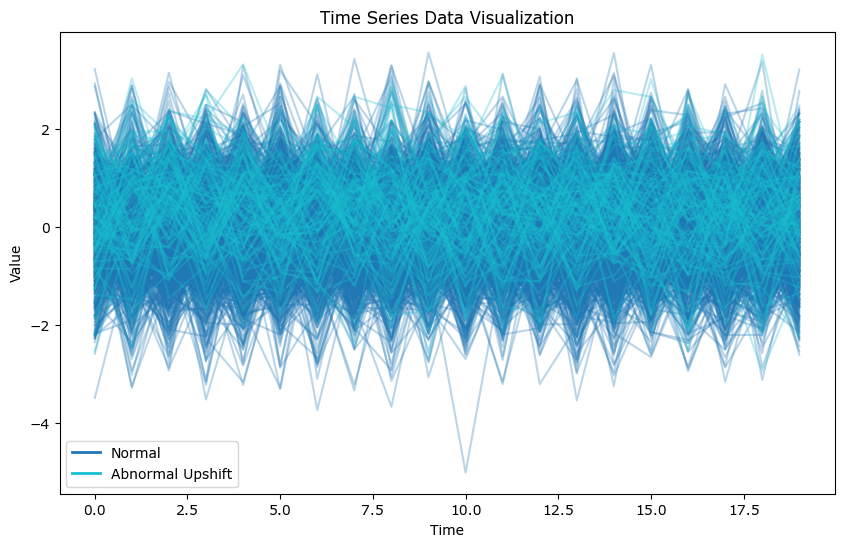

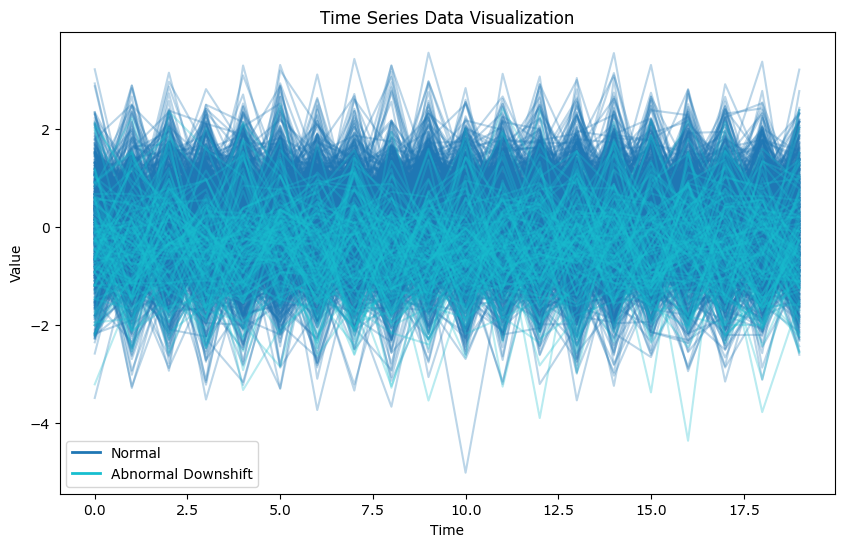

In [153]:
# Example usage for multiclass classification:
generator = TimeSeriesDataGenerator(w=20, t=0.4, a=900, b=100, mod=1)
abtypes = [1, 2, 3, 4, 5, 6, 7]
generator.generate_multiclass_data(abtypes=abtypes)
generator.visualize_data(abtypes_to_visualize=[3])

generator.visualize_data(abtypes_to_visualize=[4])

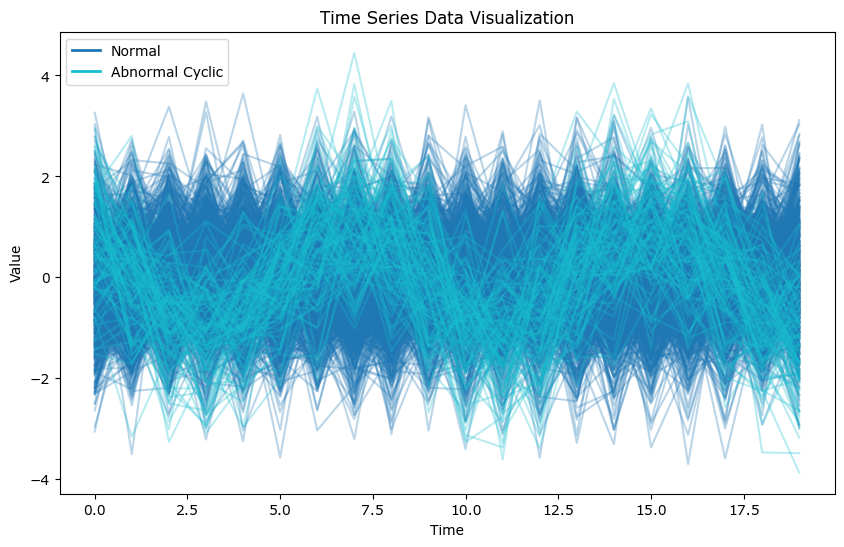

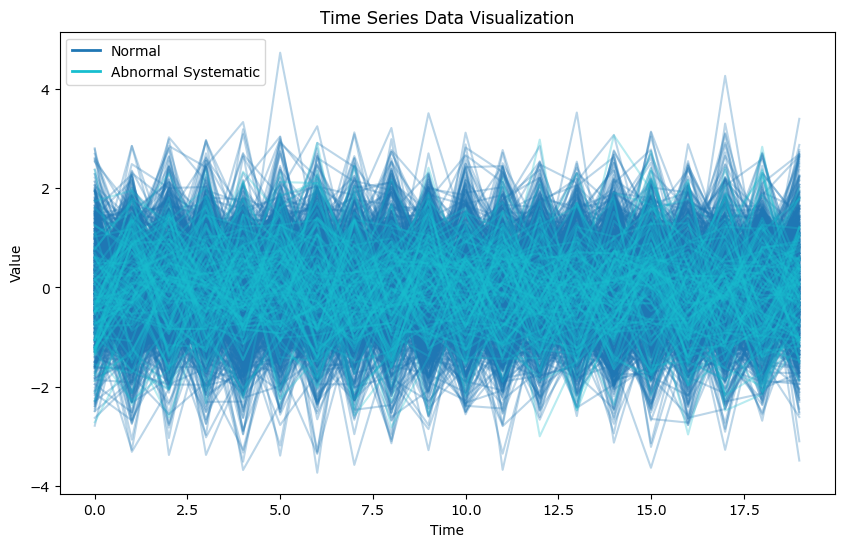

In [155]:
# Example usage for multiclass classification:
generator = TimeSeriesDataGenerator(w=20, t=1.05, a=900, b=100, mod=1)
abtypes = [1, 2, 3, 4, 5, 6, 7]
generator.generate_multiclass_data(abtypes=abtypes)
generator.visualize_data(abtypes_to_visualize=[6])


generator = TimeSeriesDataGenerator(w=20, t=0.1, a=900, b=100, mod=1)
abtypes = [1, 2, 3, 4, 5, 6, 7]
generator.generate_multiclass_data(abtypes=abtypes)
generator.visualize_data(abtypes_to_visualize=[5])


> Synthetic Data for Online learning

In [150]:
import os

os.getcwd()

'C:\\Users\\pault\\OneDrive - University of Oklahoma\\GRA - Bio-Manufacturing\\1. ML-Cytovance-OU-Research'

In [151]:
import numpy as np
import matplotlib.pyplot as plt

class TimeSeriesDataGenerator:
    def __init__(self, w, t, a, b, mod):
        self.w = w
        self.t = t
        self.a = a
        self.b = b
        self.mod = mod
        self.data = None
        self.labels = None
        self.weights = None
        self.binary = False

    def generate_binary_class_data(self, abtype):
        s = np.arange(1, self.w + 1)
        data1 = np.random.randn(self.a, self.w)

        data2 = np.zeros((self.b, self.w))
        for i in range(self.b):
            if abtype == 1:
                data2[i] = np.random.randn(self.w) + self.t * s
            elif abtype == 2:
                data2[i] = np.random.randn(self.w) - self.t * s
            elif abtype == 3:
                data2[i] = np.random.randn(self.w) + self.t * np.ones(self.w)
            elif abtype == 4:
                data2[i] = np.random.randn(self.w) - self.t * np.ones(self.w)
            elif abtype == 5:
                data2[i] = np.random.randn(self.w) + self.t * (-1) ** s
            elif abtype == 6:
                data2[i] = np.random.randn(self.w) + self.t * np.cos(2 * np.pi * s / 8)
            elif abtype == 7:
                data2[i] = self.t * np.random.randn(self.w)

        data = np.vstack((data1, data2))
        labels = np.hstack((np.ones(self.a), np.zeros(self.b)))
        data = np.hstack((data, labels.reshape(-1, 1)))

        if self.mod == 2:
            weights = np.hstack((np.ones(self.a) / self.a, np.ones(self.b) / self.b))
        else:
            weights = np.ones(self.a + self.b)

        data = np.hstack((data, weights.reshape(-1, 1)))

        self.data = data
        self.labels = labels
        self.weights = weights
        self.binary = True

    def generate_multiclass_data(self, abtypes):
        s = np.arange(1, self.w + 1)
        num_classes = len(abtypes) + 1
        data1 = np.random.randn(self.a, self.w)

        data2 = []
        labels = []

        for idx, abtype in enumerate(abtypes, start=1):
            for _ in range(self.b):
                if abtype == 1:
                    data = np.random.randn(self.w) + self.t * s
                elif abtype == 2:
                    data = np.random.randn(self.w) - self.t * s
                elif abtype == 3:
                    data = np.random.randn(self.w) + self.t * np.ones(self.w)
                elif abtype == 4:
                    data = np.random.randn(self.w) - self.t * np.ones(self.w)
                elif abtype == 5:
                    data = np.random.randn(self.w) + self.t * (-1) ** s
                elif abtype == 6:
                    data = np.random.randn(self.w) + self.t * np.cos(2 * np.pi * s / 8)
                elif abtype == 7:
                    data = self.t * np.random.randn(self.w)
                data2.append(data)
                labels.append(idx)

        data2 = np.array(data2)
        data = np.vstack((data1, data2))
        labels = np.hstack((np.zeros(self.a), np.array(labels)))
        data = np.hstack((data, labels.reshape(-1, 1)))

        if self.mod == 2:
            weights_normal = np.ones(self.a) / self.a
            weights_abnormal = np.ones(len(labels) - self.a) / self.b
            weights = np.hstack((weights_normal, weights_abnormal))
        else:
            weights = np.ones(self.a + len(labels) - self.a)

        data = np.hstack((data, weights.reshape(-1, 1)))

        self.data = data
        self.labels = labels
        self.weights = weights
        self.binary = False

    def get_data(self):
        if self.data is None:
            raise ValueError("Data not generated. Please call generate_data() first.")
        return self.data[:, :-2]

    def get_labels(self):
        if self.labels is None:
            raise ValueError("Data not generated. Please call generate_data() first.")
        return self.labels

    def get_weights(self):
        if self.weights is None:
            raise ValueError("Data not generated. Please call generate_data() first.")
        return self.weights

    def visualize_data(self, abtypes_to_visualize=None):
        if self.data is None:
            raise ValueError("Data not generated. Please call generate_data() first.")
        
        plt.figure(figsize=(10, 6))

        abtype_names = {
            1: 'Uptrend',
            2: 'Downtrend',
            3: 'Upshift',
            4: 'Downshift',
            5: 'Systematic',
            6: 'Cyclic',
            7: 'Stratification'
        }

        if self.binary:
            label_names = {0: 'Abnormal', 1: 'Normal'}
        else:
            if abtypes_to_visualize is None:
                abtypes_to_visualize = list(abtype_names.keys())
            label_names = {0: 'Normal'}
            for idx in abtypes_to_visualize:
                label_names[idx] = f'Abnormal {abtype_names[idx]}'

        colors = plt.cm.get_cmap('tab10', len(label_names))

        for i in range(len(self.labels)):
            label = int(self.data[i, -2])
            if label in label_names:
                plt.plot(self.data[i, :-2], color=colors(label), alpha=0.3, label=label_names[label] if i == 0 else "")

        handles = []
        for label, name in label_names.items():
            handles.append(plt.Line2D([0], [0], color=colors(label), lw=2, label=name))
        plt.legend(handles=handles)

        plt.title('Time Series Data Visualization')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.show()


def save_libsvm_format(data, labels, filename):
    with open(filename, 'w') as f:
        for i in range(data.shape[0]):
            label = int(labels[i])
            features = ' '.join(f"{j+1}:{data[i,j]:.6f}" for j in range(data.shape[1]))
            f.write(f"{label} {features}\n")

# Example usage for binary classification:
generator = TimeSeriesDataGenerator(w=48, t=0.5, a=20, b=10, mod=1)
generator.generate_binary_class_data(abtype=1)
binary_data = generator.get_data()
binary_labels = generator.get_labels()
save_libsvm_format(binary_data, binary_labels, 'titer\summer\binary_synthetic_data.libsvm')

# Example usage for multiclass classification:
generator = TimeSeriesDataGenerator(w=48, t=0.5, a=20, b=10, mod=1)
abtypes = [1, 2, 3, 4, 5, 6, 7]
generator.generate_multiclass_data(abtypes=abtypes)
multiclass_data = generator.get_data()
multiclass_labels = generator.get_labels()
save_libsvm_format(multiclass_data, multiclass_labels, 'titer\summer\multiclass_synthetic_data.libsvm')


In [147]:
## Running binary classification with OGD algorithm
# python run.py -a OGD -t bc -d binary_synthetic_data.libsvm -f libsvm

## Running multiclass classification with M_PA2 algorithm
# python run.py -a M_PA2 -t mc -d multiclass_synthetic_data.libsvm -f libsvm


# -d : Path to training dataset

# -t : Type of problem to solve, possible options are:
#      bc - Binary Classification
#      mc - Multiclass Classification
#  -f : File format of input data, formats supported are:
#      libsvm

#  -n : Number of runs for each algorithm (Results displayed are average values)


> Control Chart Pattern Recognition on E. coli Dataset

In [11]:
# Control variables
    # Feed Type --> not in the dataset since it is invariant 
    # output_Ph (pH)
    # output_Temp (Temperature)
    # output_D0_% (Dissolved Oxygen Percentage)
    # Induction OD/Feed OD --> not in the dataset 

# Other Features
    # input_Timepoint (hr)
    # output_OD600 (OD600nm)
    # output_WCW_gl (Wet cell weight)
    # Agitation   (output_agitation)
    # output_air_% (Air)
    # output_gasflow (Gas Flow)
    # output_O2 (Oxygen)
    # output_feed_% (Feed Percentage)
    # output_feed (Feed)
    # output_glycerol_gl (Glycerol)
    # output_glucose_gl (Glucose)
    # output_acetate_mmol_l (Acetate)
    # output_phosphate_mmol_l (Phosphate)
    
# Target variable
    # output_titre_µgl (Titer)


In [ ]:
# Without Weighting (Not Cost-Sensitive)
# Part A: Base Parameters
# Uptrend: w = 20, t = 0.2 (abnormal values/parameters)
python data_generator.py -t bc -d data/01_uptrend_base.libsvm -w 20 --t 0.2 -a 900 -b 100 -m 1 --abtype 1
# Downtrend: w = 20, t = 0.2
python data_generator.py -t bc -d data/02_downtrend_base.libsvm -w 20 --t 0.2 -a 900 -b 100 -m 1 --abtype 2
# Upshift: w=20, t = 0.4 (abnormal values/parameters)
python data_generator.py -t bc -d data/03_upshift_base.libsvm -w 20 --t 0.4 -a 900 -b 100 -m 1 --abtype 3
# Downshift: w=20, t = 0.4 (abnormal values/parameters)
python data_generator.py -t bc -d data/04_downshift_base.libsvm -w 20 --t 0.4 -a 900 -b 100 -m 1 --abtype 4
# Systematic: w=20, t=0.1 (abnormal values/parameters)
python data_generator.py -t bc -d data/05_systematic_base.libsvm -w 20 --t 0.1 -a 900 -b 100 -m 1 --abtype 5
# Cyclic: w=20, t = 1.05 (abnormal values/parameters)
python data_generator.py -t bc -d data/06_cyclic_base.libsvm -w 20 --t 1.05 -a 900 -b 100 -m 1 --abtype 6
# Stratification: w=20, t=0.25 (abnormal values/parameters)
python data_generator.py -t bc -d data/07_stratification_base.libsvm -w 20 --t 0.25 -a 900 -b 100 -m 1 --abtype 7

# Part B: Variation in Parameters
# Uptrend: w=20, t = 0.25
python data_generator.py -t bc -d data/08_uptrend_variation.libsvm -w 20 --t 0.25 -a 900 -b 100 -m 1 --abtype 1
# Downtrend: w=20, t = 0.25
python data_generator.py -t bc -d data/09_downtrend_variation.libsvm -w 20 --t 0.25 -a 900 -b 100 -m 1 --abtype 2
# Upshift: w=20, t = 0.45
python data_generator.py -t bc -d data/10_upshift_variation.libsvm -w 20 --t 0.45 -a 900 -b 100 -m 1 --abtype 3
# Downshift: w=20, t = 0.45
python data_generator.py -t bc -d data/11_downshift_variation.libsvm -w 20 --t 0.45 -a 900 -b 100 -m 1 --abtype 4
# Systematic: w=20, t = 0.15
python data_generator.py -t bc -d data/12_systematic_variation.libsvm -w 20 --t 0.15 -a 900 -b 100 -m 1 --abtype 5
# Cyclic: w=20, t = 1.1
python data_generator.py -t bc -d data/13_cyclic_variation.libsvm -w 20 --t 1.1 -a 900 -b 100 -m 1 --abtype 6
# Stratification: w=20, t = 0.3
python data_generator.py -t bc -d data/14_stratification_variation.libsvm -w 20 --t 0.3 -a 900 -b 100 -m 1 --abtype 7

# With Weighting (Cost-Sensitive)
# Part C: Base Parameters
# Uptrend: w = 20, t = 0.2 (abnormal values/parameters)
python data_generator.py -t bc -d data/15_uptrend_base_weighted.libsvm -w 20 --t 0.2 -a 900 -b 100 -m 2 --abtype 1
# Downtrend: w = 20, t = 0.2
python data_generator.py -t bc -d data/16_downtrend_base_weighted.libsvm -w 20 --t 0.2 -a 900 -b 100 -m 2 --abtype 2
# Upshift: w=20, t = 0.4 (abnormal values/parameters)
python data_generator.py -t bc -d data/17_upshift_base_weighted.libsvm -w 20 --t 0.4 -a 900 -b 100 -m 2 --abtype 3
# Downshift: w=20, t = 0.4 (abnormal values/parameters)
python data_generator.py -t bc -d data/18_downshift_base_weighted.libsvm -w 20 --t 0.4 -a 900 -b 100 -m 2 --abtype 4
# Systematic: w=20, t=0.1 (abnormal values/parameters)
python data_generator.py -t bc -d data/19_systematic_base_weighted.libsvm -w 20 --t 0.1 -a 900 -b 100 -m 2 --abtype 5
# Cyclic: w=20, t = 1.05 (abnormal values/parameters)
python data_generator.py -t bc -d data/20_cyclic_base_weighted.libsvm -w 20 --t 1.05 -a 900 -b 100 -m 2 --abtype 6
# Stratification: w=20, t=0.25 (abnormal values/parameters)
python data_generator.py -t bc -d data/21_stratification_base_weighted.libsvm -w 20 --t 0.25 -a 900 -b 100 -m 2 --abtype 7

# Part D: Variation in Parameters
# Uptrend: w=20, t = 0.25
python data_generator.py -t bc -d data/22_uptrend_variation_weighted.libsvm -w 20 --t 0.25 -a 900 -b 100 -m 2 --abtype 1
# Downtrend: w=20, t = 0.25
python data_generator.py -t bc -d data/23_downtrend_variation_weighted.libsvm -w 20 --t 0.25 -a 900 -b 100 -m 2 --abtype 2
# Upshift: w=20, t = 0.45
python data_generator.py -t bc -d data/24_upshift_variation_weighted.libsvm -w 20 --t 0.45 -a 900 -b 100 -m 2 --abtype 3
# Downshift: w=20, t = 0.45
python data_generator.py -t bc -d data/25_downshift_variation_weighted.libsvm -w 20 --t 0.45 -a 900 -b 100 -m 2 --abtype 4
# Systematic: w=20, t = 0.15
python data_generator.py -t bc -d data/26_systematic_variation_weighted.libsvm -w 20 --t 0.15 -a 900 -b 100 -m 2 --abtype 5
# Cyclic: w=20, t = 1.1
python data_generator.py -t bc -d data/27_cyclic_variation_weighted.libsvm -w 20 --t 1.1 -a 900 -b 100 -m 2 --abtype 6
# Stratification: w=20, t = 0.3
python data_generator.py -t bc -d data/28_stratification_variation_weighted.libsvm -w 20 --t 0.3 -a 900 -b 100 -m 2 --abtype 7
